$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 5 $$

# `01` Assignment 01

- Design your LSTM learning model to classify hand-written digits (MNIST dataset).
- To handle images as a sequence, the LSTM input can be seen as a 28 sequences
of 28 elements each (taking each row of pixels as a single time step input).
- Then, you can use dense layer(s) on top (connected to the
output of the LSTM).
- Important Notes:
  - Image Size: $28\times28$
  - Use $80\%$ of the provided training data for training and $20\%$ for validation (Keep the test data for testing after training).
  - Use $32$ units in the LSTM layer and $15\%$ recurrent dropout.
  - Use Categorical Cross Entropy for the loss calculation, `Adam` for optimization and `accuracy` for metrics.


  **Additional Requirements**:
  - Try adding a second LSTM layer before the dense layer(s).
  - Change the number of cells to $48, 96, 256$ and report the accuracy curve.

## `+` Import Libraries

In [1]:
import os
import sys
import pathlib
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import ConvLSTM1D, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping




In [2]:
%matplotlib inline

# `+` Seed Value

In [3]:
SEED = 907

## `+` Load & Preprocess MNIST Dataset

**Reminder:** You might need rescaling, and/or other preprocessing methods.

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
print('x_train type:', type(x_train), ',', 'y_train type:', type(y_train))
print('x_train dtype:', x_train.dtype, ',', 'y_train dtype:', y_train.dtype)
print('x_train shape:', x_train.shape, ',', 'y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape, ',', 'y_test shape:', y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train type: <class 'numpy.ndarray'> , y_train type: <class 'numpy.ndarray'>
x_train dtype: uint8 , y_train dtype: uint8
x_train shape: (60000, 28, 28) , y_train shape: (60000,)
x_test shape: (10000, 28, 28) , y_test shape: (10000,)
60000 train samples
10000 test samples


In [6]:
x_train[0],y_train[0]

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
           0

In [7]:
def to_image(arr):
    if len(arr.shape) == 3 and arr.shape[-1] == 3:
        return arr
    elif len(arr.shape) == 3 and arr.shape[-1] == 1:
        return arr.reshape(arr.shape[0:-1])
    elif len(arr.shape) == 1 and np.sqrt(arr.shape[0]) == int(np.sqrt(arr.shape[0])):
        return arr.reshape((int(np.sqrt(arr.shape[0])), int(np.sqrt(arr.shape[0]))))
    else:
        return arr # Give up, let `matplotlib` `imshow` complain about malformed image.

def imageset_plot(x_train, y_train, no_images=15,seed=907):
    fig = plt.figure(figsize=(8,4))
    random.seed(seed)

    for i in range(no_images):
        plt.subplot(3, int(no_images/3), i + 1)
        plt.xticks([])
        plt.yticks([])
        idx = int(random.uniform(0, x_train.shape[0])) # get random idx
        plt.title("%s" % (y_train[idx]))
        plt.imshow(x_train[idx], cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.show()

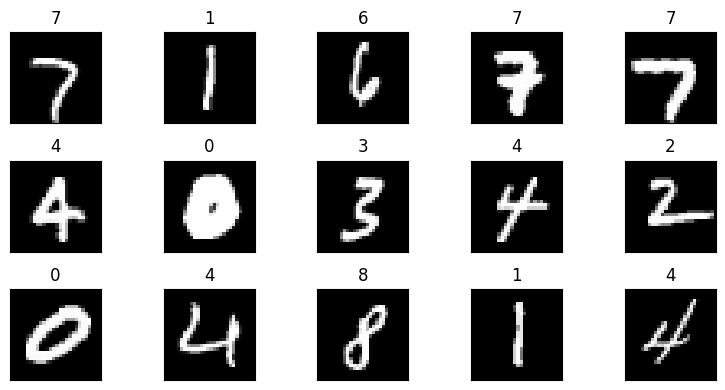

In [8]:
imageset_plot(x_train, y_train,no_images=15)

In [9]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [10]:
# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)



In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

In [12]:
print('x_train type:', type(x_train), ',', 'y_train type:', type(y_train))
print('x_train dtype:', x_train.dtype, ',', 'y_train dtype:', y_train.dtype)
print('x_train shape:', x_train.shape, ',', 'y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape, ',', 'y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape, ',', 'y_test shape:', y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')
print(x_test.shape[0], 'test samples')


x_train type: <class 'numpy.ndarray'> , y_train type: <class 'numpy.ndarray'>
x_train dtype: float32 , y_train dtype: float64
x_train shape: (48000, 28, 28) , y_train shape: (48000, 10)
x_val shape: (12000, 28, 28) , y_val shape: (12000, 10)
x_test shape: (10000, 28, 28) , y_test shape: (10000, 10)
48000 train samples
12000 val samples
10000 test samples


## `+` Set Global Parameters

In [13]:
BATCH_SIZE  = 64
EPOCHS      = 50

## `i` Model Design

In [14]:
# 32 cells with 0.15 dropout
model = Sequential()
model.add(LSTM(32, input_shape=(28, 28), return_sequences=True, recurrent_dropout=0.15))
model.add(LSTM(32, recurrent_dropout=0.15))
model.add(Dense(10, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 28, 32)         │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,458 (64.29 KB)

 Trainable params: 16,458 (64.29 KB)

 Non-trainable params: 0 (0.00 B)

## `ii` Model Compilation & Training

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [17]:
history = model.fit(
  x_train, y_train,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  validation_data=(x_val, y_val),
  callbacks=[early_stop],
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 98ms/step - accuracy: 0.5292 - loss: 1.3836 - val_accuracy: 0.8928 - val_loss: 0.3561
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 71s 86ms/step - accuracy: 0.8807 - loss: 0.3872 - val_accuracy: 0.9443 - val_loss: 0.1900
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.9302 - loss: 0.2320 - val_accuracy: 0.9607 - val_loss: 0.1359
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 68s 91ms/step - accuracy: 0.9503 - loss: 0.1684 - val_accuracy: 0.9702 - val_loss: 0.1086
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.9601 - loss: 0.1370 - val_accuracy: 0.9705 - val_loss: 0.0969
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.9652 - loss: 0.1135 - val_accuracy: 0.9771 - val_loss: 0.0772
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.9703 - loss: 0.0978 - val_accuracy: 0.9805 - val_loss: 0.0661
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.9751 - loss: 0.0848 - 

## `iii` Model Evaluation

In [18]:
loss_train_1, accuracy_train_1 = model.evaluate(x_train, y_train)
print(f"Accuracy for training: {accuracy_train_1:.2%}")
loss_test_1, accuracy_test_1 = model.evaluate(x_test, y_test)
print(f"Accuracy for Test: {accuracy_test_1:.2%}")

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.9930 - loss: 0.0237
Accuracy for training: 99.34%
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9857 - loss: 0.0493
Accuracy for Test: 98.81%


## `iv` Result Visualization

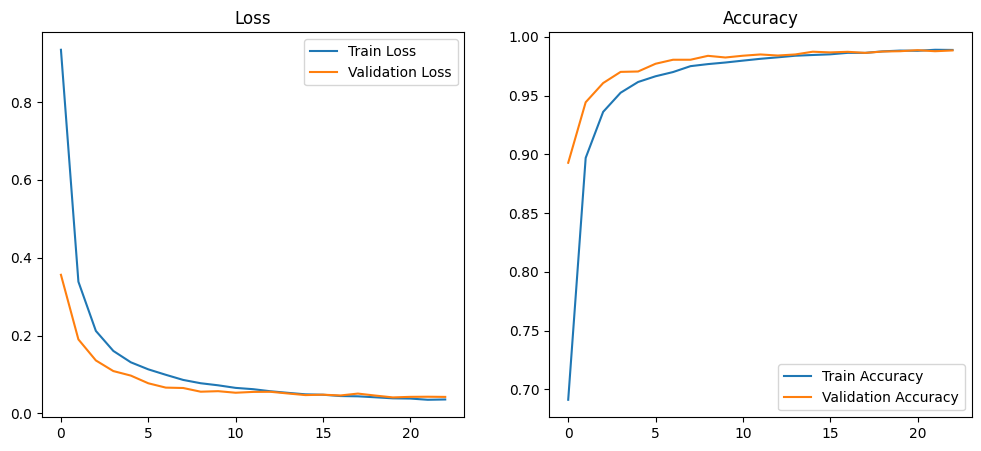

In [19]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [20]:
# Plot the training and validation accuracy and loss


## `v` Let's Visualize Model Predictions

Let's try to predict the class of some test samples and plot the results.

In [21]:

def plot_predictions_subset(y_pred, x_test, y_test, n=5):
    pred_labels = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    # Choose a random subset of n samples
    indices = np.random.choice(len(x_test), n, replace=False)

    # Plot the selected samples
    plt.figure(figsize=(4 * n, 4))
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(x_test[idx], cmap='gray')
        plt.title(
            rf"$y_{{true}}$: {true_labels[idx]} | $y_{{pred}}$: {pred_labels[idx]}",
            fontsize=14
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


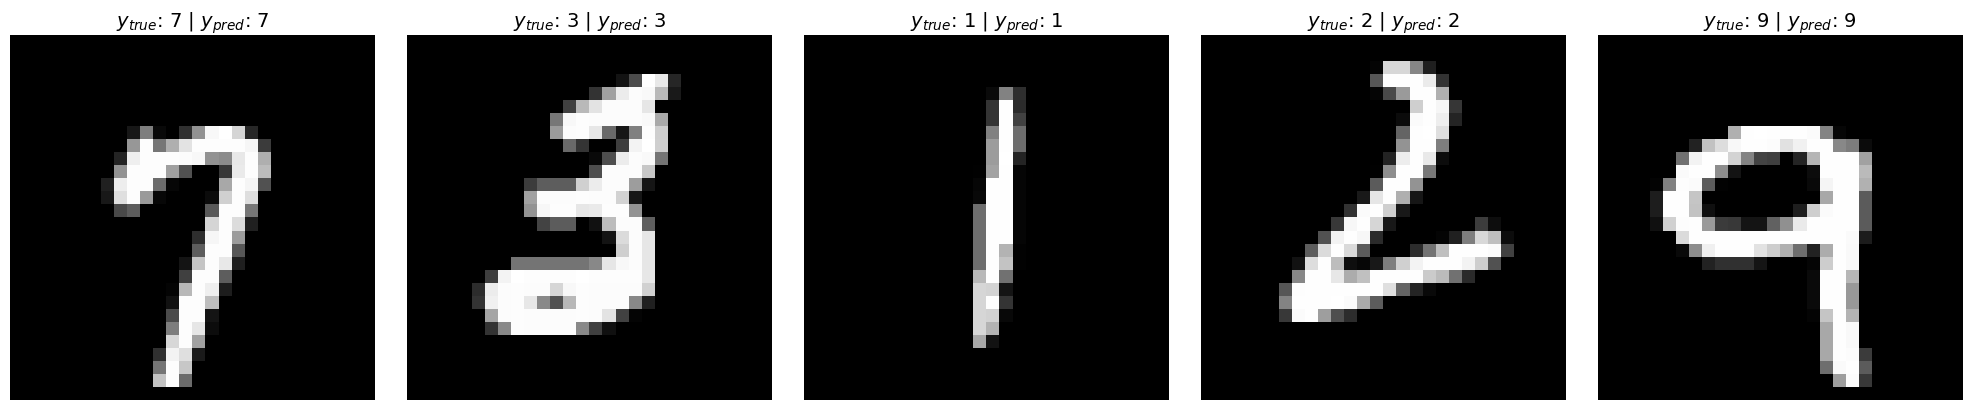

In [22]:
y_pred = model.predict(x_test)
plot_predictions_subset(y_pred, x_test, y_test, n=5)


In [23]:
# Plot the Input, True Label, and Predicted Label


**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Assignment 02
- Repeat assignment `01` using `ConvLSTM1D` layer instead of `LSTM`: An LSTM utilizing the power of convolutions. Read more [here](https://paperswithcode.com/method/convlstm) and [here](https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7).
- Use the same parameters from assignment `01` in addition to:
  - Kernel Size -> Try $1$ and $3$. Which is better?
  - Padding = `same` or `valid` -> Is there a big difference?

**Note:** You might need to reshape the input (Hint: check `keras.layers.Reshape` layer)


IMPORTANT NOTE: Make sure to organize your solution, add proper documentation, and report your insights.
------------------------------

In [24]:
# Reshape for ConvLSTM1D: (samples, time_steps, input_dim, channels)
# Treat each image row as a time step: (28 time steps, 28 features)
# ConvLSTM1D expects input shape: (time_steps, length, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
print(x_train.shape, x_val.shape, x_test.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1)


## Kernel 1, padding = 'same'

In [25]:
model_convLstm = Sequential()
model_convLstm.add(ConvLSTM1D(
    filters=32,
    kernel_size=1,
    padding='same',
    activation='tanh',
    recurrent_dropout=0.15,
    return_sequences=False,
    input_shape=(28, 28, 1)
))
model_convLstm.add(Flatten())
model_convLstm.add(Dense(10, activation='softmax'))

model_convLstm.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)
model_convLstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)        │ (None, 28, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         8,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,322 (52.04 KB)

 Trainable params: 13,322 (52.04 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history_lstm = model_convLstm.fit(
  x_train, y_train,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  validation_data=(x_val, y_val),
  callbacks=[early_stop],
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.5647 - loss: 1.2922 - val_accuracy: 0.8735 - val_loss: 0.3965
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8701 - loss: 0.4172 - val_accuracy: 0.9085 - val_loss: 0.2839
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9054 - loss: 0.3019 - val_accuracy: 0.9264 - val_loss: 0.2378
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9226 - loss: 0.2478 - val_accuracy: 0.9404 - val_loss: 0.1874
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9365 - loss: 0.2099 - val_accuracy: 0.9433 - val_loss: 0.1749
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9410 - loss: 0.1916 - val_accuracy: 0.9513 - val_loss: 0.1592
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9441 - loss: 0.1798 - val_accuracy: 0.9564 - val_loss: 0.1411
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9499 - loss: 0.1621 - 

In [27]:
loss_train_1, accuracy_train_1 = model_convLstm.evaluate(x_train, y_train)
print(f"Accuracy for training: {accuracy_train_1:.2%}")
loss_test_1, accuracy_test_1 = model_convLstm.evaluate(x_test, y_test)
print(f"Accuracy for Test: {accuracy_test_1:.2%}")

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9715 - loss: 0.0942
Accuracy for training: 97.15%
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9646 - loss: 0.1235
Accuracy for Test: 96.81%


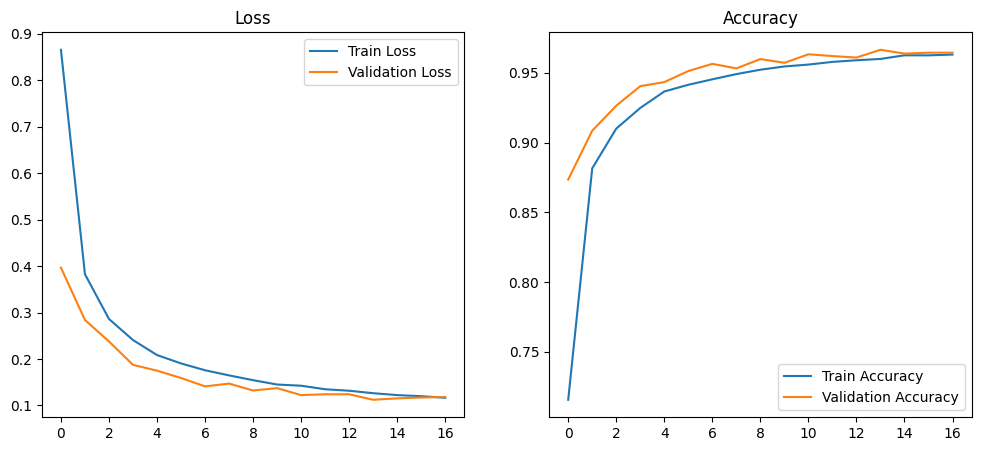

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## Kernel 1 padding 'valid'

In [29]:
model_convLstm_valid = Sequential()
model_convLstm_valid.add(ConvLSTM1D(
    filters=32,
    kernel_size=1,
    padding='valid',
    activation='tanh',
    recurrent_dropout=0.15,
    return_sequences=False,
    input_shape=(28, 28, 1)
))
model_convLstm_valid.add(Flatten())
model_convLstm_valid.add(Dense(10, activation='softmax'))

model_convLstm_valid.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)
model_convLstm_valid.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm1d_1 (ConvLSTM1D)      │ (None, 28, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         8,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,322 (52.04 KB)

 Trainable params: 13,322 (52.04 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history_lstm_valid = model_convLstm_valid.fit(
  x_train, y_train,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  validation_data=(x_val, y_val),
  callbacks=[early_stop],
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5486 - loss: 1.3109 - val_accuracy: 0.8802 - val_loss: 0.3880
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.8659 - loss: 0.4171 - val_accuracy: 0.9108 - val_loss: 0.2817
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9090 - loss: 0.2945 - val_accuracy: 0.9225 - val_loss: 0.2513
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9224 - loss: 0.2491 - val_accuracy: 0.9433 - val_loss: 0.1855
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9330 - loss: 0.2219 - val_accuracy: 0.9483 - val_loss: 0.1697
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9425 - loss: 0.1904 - val_accuracy: 0.9498 - val_loss: 0.1624
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9476 - loss: 0.1743 - val_accuracy: 0.9529 - val_loss: 0.1523
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9506 - loss: 0.1640 - 

In [31]:
loss_train_1, accuracy_train_1 = model_convLstm_valid.evaluate(x_train, y_train)
print(f"Accuracy for training: {accuracy_train_1:.2%}")
loss_test_1, accuracy_test_1 = model_convLstm_valid.evaluate(x_test, y_test)
print(f"Accuracy for Test: {accuracy_test_1:.2%}")

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9796 - loss: 0.0633
Accuracy for training: 97.99%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9672 - loss: 0.1099
Accuracy for Test: 97.23%


In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_valid.history['loss'], label='Train Loss')
plt.plot(history_lstm_valid.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_lstm_valid.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_valid.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## Kernel 3 padding 'same'

In [33]:
model_convLstm_same = Sequential()
model_convLstm_same.add(ConvLSTM1D(
    filters=32,
    kernel_size=3,
    padding='same',
    activation='tanh',
    recurrent_dropout=0.15,
    return_sequences=False,
    input_shape=(28, 28, 1)
))
model_convLstm_same.add(Flatten())
model_convLstm_same.add(Dense(10, activation='softmax'))

model_convLstm_same.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)
model_convLstm_same.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm1d_2 (ConvLSTM1D)      │ (None, 28, 32)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         8,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,770 (85.04 KB)

 Trainable params: 21,770 (85.04 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history_lstm_same = model_convLstm_same.fit(
  x_train, y_train,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  validation_data=(x_val, y_val),
  callbacks=[early_stop],
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6562 - loss: 1.0049 - val_accuracy: 0.9243 - val_loss: 0.2422
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9181 - loss: 0.2565 - val_accuracy: 0.9538 - val_loss: 0.1430
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9437 - loss: 0.1819 - val_accuracy: 0.9663 - val_loss: 0.1107
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9572 - loss: 0.1366 - val_accuracy: 0.9693 - val_loss: 0.0956
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9638 - loss: 0.1156 - val_accuracy: 0.9739 - val_loss: 0.0798
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9694 - loss: 0.0987 - val_accuracy: 0.9773 - val_loss: 0.0687
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9729 - loss: 0.0891 - val_accuracy: 0.9787 - val_loss: 0.0683
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9743 - loss: 0.0803 - 

In [38]:
loss_train_1, accuracy_train_1 = model_convLstm_same.evaluate(x_train, y_train)
print(f"Accuracy for training: {accuracy_train_1:.2%}")
loss_test_1, accuracy_test_1 = model_convLstm_same.evaluate(x_test, y_test)
print(f"Accuracy for Test: {accuracy_test_1:.2%}")

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9897 - loss: 0.0336
Accuracy for training: 99.00%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9818 - loss: 0.0569
Accuracy for Test: 98.56%


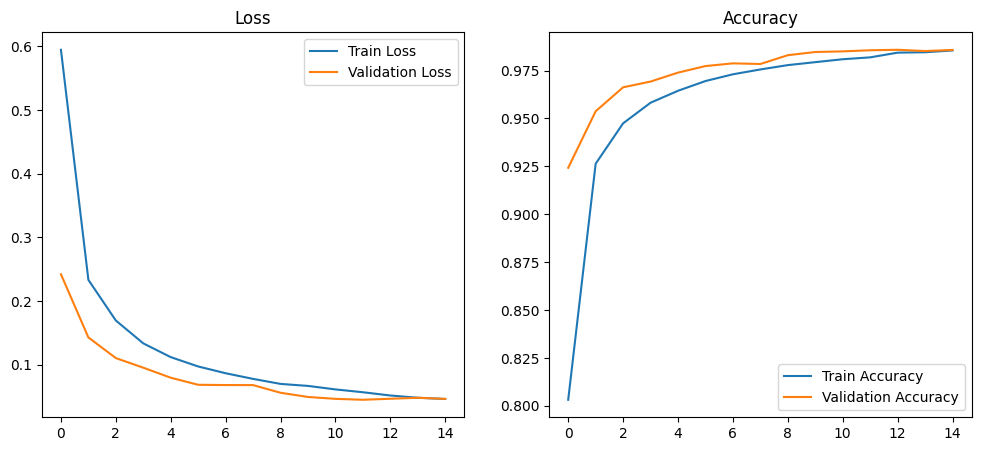

In [39]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_same.history['loss'], label='Train Loss')
plt.plot(history_lstm_same.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_lstm_same.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_same.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## Kernel 3 padding 'valid'

In [35]:
model_convLstm_3 = Sequential()
model_convLstm_3.add(ConvLSTM1D(
    filters=32,
    kernel_size=3,
    padding='valid',
    activation='tanh',
    recurrent_dropout=0.15,
    return_sequences=False,
    input_shape=(28, 28, 1)
))
model_convLstm_3.add(Flatten())
model_convLstm_3.add(Dense(10, activation='softmax'))

model_convLstm_3.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)
model_convLstm_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm1d_3 (ConvLSTM1D)      │ (None, 26, 32)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         8,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,130 (82.54 KB)

 Trainable params: 21,130 (82.54 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history_convLstm_3 = model_convLstm_3.fit(
  x_train, y_train,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  validation_data=(x_val, y_val),
  callbacks=[early_stop],
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.6800 - loss: 0.9592 - val_accuracy: 0.9223 - val_loss: 0.2507
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9240 - loss: 0.2454 - val_accuracy: 0.9590 - val_loss: 0.1339
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9483 - loss: 0.1672 - val_accuracy: 0.9663 - val_loss: 0.1088
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9605 - loss: 0.1263 - val_accuracy: 0.9700 - val_loss: 0.1052
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9666 - loss: 0.1089 - val_accuracy: 0.9771 - val_loss: 0.0748
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9706 - loss: 0.0944 - val_accuracy: 0.9778 - val_loss: 0.0738
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9745 - loss: 0.0838 - val_accuracy: 0.9796 - val_loss: 0.0634
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9795 - loss: 0.0681 - 

In [40]:
loss_train_1, accuracy_train_1 = model_convLstm_3.evaluate(x_train, y_train)
print(f"Accuracy for training: {accuracy_train_1:.2%}")
loss_test_1, accuracy_test_1 = model_convLstm_3.evaluate(x_test, y_test)
print(f"Accuracy for Test: {accuracy_test_1:.2%}")

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9966 - loss: 0.0107
Accuracy for training: 99.66%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9866 - loss: 0.0428
Accuracy for Test: 98.95%


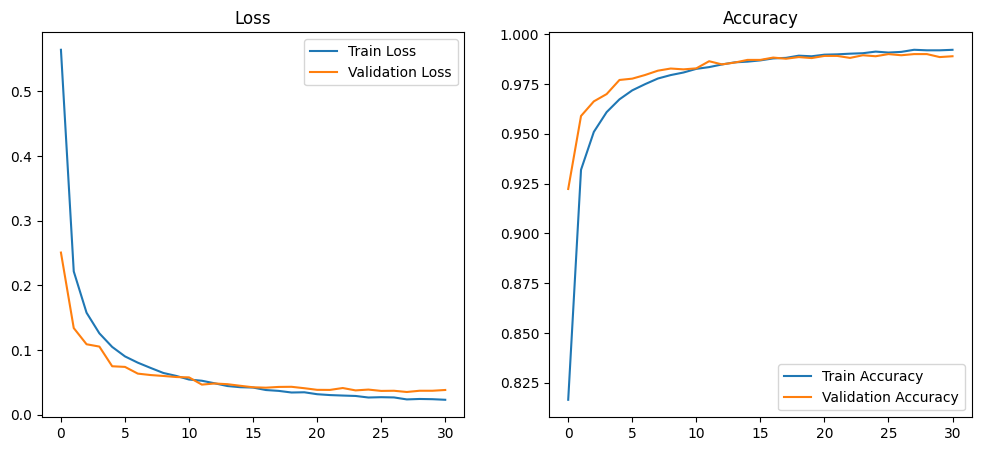

In [41]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_convLstm_3.history['loss'], label='Train Loss')
plt.plot(history_convLstm_3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_convLstm_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_convLstm_3.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# Insights

## padding='same'
Pads the input so that the output has the same length as the input.

Adds zeros (or constant values) to the borders of the input.

This allows the convolution to “see” edge pixels more fairly.

## padding='valid'
No padding is added. Convolution is only applied where the kernel fits fully.

The output will be smaller than the input.

When kernel_size=1:

The model isn't gaining much from the surrounding context — because there isn't any.

So the benefits of "same" padding (preserving context at the edges) don't apply.

In fact, the extra handling in 'same' might slightly hurt performance.

That's why padding='valid' might slightly outperform 'same' when kernel size is 1.

When kernel_size=3:

Looks at 3 consecutive features (pixels) at each step.

`same` padding introduces zero-padding at the borders.

These artificial values may lead to false feature activations or confuse the LSTM.

In small inputs like MNIST (28×28), a few "noisy" pixels can make a difference.

`valid` avoids this — it works only on true pixel data, no assumptions.

So `valid` -- cleaner input to the LSTM layer, no padding-induced artifacts.
With a slightly shorter sequence, the LSTM has to learn simpler patterns, potentially reducing overfitting



----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$